Mounted at /content/drive
Extracting /content/drive/MyDrive/nuts/Good.zip
Extracting /content/drive/MyDrive/nuts/Defective.zip
Found: 97 good images, 96 defective images


Processing defective: 100%|██████████| 96/96 [37:11<00:00, 23.25s/it]


Saved results to: /content/drive/MyDrive/nuts_grading_results.csv
Grade
Good            97
Minor Defect    48
Major Defect    28
Reject          20
Name: count, dtype: int64


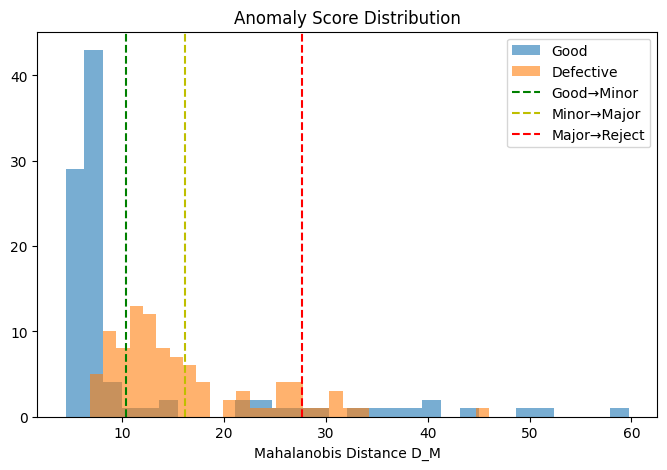

Overlay HTML index saved to /content/nuts_overlays_index.html
Pipeline finished. Results CSV and overlays saved to your Drive.


In [6]:

# 1) Install dependencies
!pip install --quiet opencv-python-headless scikit-image scikit-learn tqdm matplotlib pillow

# 2) Imports
import os, zipfile, glob, math, time
from tqdm import tqdm
import numpy as np
import cv2
from skimage.feature import local_binary_pattern
from skimage.filters import gabor
from skimage.morphology import skeletonize, disk, opening
from skimage import img_as_ubyte
from sklearn.covariance import MinCovDet
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import warnings
warnings.filterwarnings('ignore')

# 3) Mount Drive (Colab)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

DRIVE_BASE = '/content/drive/MyDrive/nuts'
GOOD_ZIP = os.path.join(DRIVE_BASE, 'Good.zip')
DEF_ZIP = os.path.join(DRIVE_BASE, 'Defective.zip')

# 5) Extraction path
EXTRACT_PATH = '/content/nuts_data'
os.makedirs(EXTRACT_PATH, exist_ok=True)

for zp in [GOOD_ZIP, DEF_ZIP]:
    if not os.path.exists(zp):
        print(f"WARNING: not found zip: {zp}")
    else:
        print("Extracting", zp)
        with zipfile.ZipFile(zp, 'r') as z:
            z.extractall(EXTRACT_PATH)

# 6) Utilities and pipeline components

def msrcr(img, scales=[15,80,250], weights=[0.33,0.33,0.34]):
    """Simple Multi-Scale Retinex with color restoration (practical approx)."""
    img = img.astype(np.float32) + 1.0
    log_img = np.log(img)
    ret = np.zeros_like(img)
    for s,w in zip(scales, weights):
        blur = cv2.GaussianBlur(img, (0,0), s)
        ret += w * (log_img - np.log(blur + 1.0))
    # color restoration via scaling
    ret = np.exp(ret) - 1.0
    ret = np.clip(ret, 0, 255).astype(np.uint8)
    return ret

def resize_keep_aspect(img, target_width=512):
    h,w = img.shape[:2]
    if w <= target_width:
        return img
    scale = target_width / w
    return cv2.resize(img, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)

def segment_mask(gray):
    """Segment nut using Otsu + morphology. Returns mask (uint8 0/255)."""
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    _, mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((9,9), np.uint8))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((5,5), np.uint8))
    # fill holes
    cnts, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(cnts) == 0:
        return mask
    main = max(cnts, key=cv2.contourArea)
    mask2 = np.zeros_like(mask)
    cv2.drawContours(mask2, [main], -1, 255, -1)
    return mask2

def fit_and_align(img, mask):
    """Fit ellipse and rotate image/mask to canonical orientation."""
    cnts, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return img, mask, 0.0
    cnt = max(cnts, key=cv2.contourArea)
    if len(cnt) < 5:
        return img, mask, 0.0
    ellipse = cv2.fitEllipse(cnt)
    angle = ellipse[2]
    # rotate around center
    (h,w) = img.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
    img_r = cv2.warpAffine(img, M, (w,h), flags=cv2.INTER_LINEAR)
    mask_r = cv2.warpAffine(mask, M, (w,h), flags=cv2.INTER_NEAREST)
    return img_r, mask_r, angle

def approx_sfs(gray, mask, n_iters=200, lam=0.2):
    """
    Simple approximate SFS: estimate depth z by iteratively smoothing the depth while matching I ~ N.L
    This is a simplified proxy to produce a 'height-like' map. Not physically exact but useful.
    """
    # normalize
    I = gray.astype(np.float32) / 255.0
    # initialize z to zeros
    z = np.zeros_like(I)
    # estimate light direction approx from global gradient
    gy, gx = np.gradient(I)
    # dominant gradient direction (mean)
    gx_m = np.mean(gx[mask>0]); gy_m = np.mean(gy[mask>0])
    Lx, Ly = -gx_m, -gy_m
    Lz = 1.0
    # iterative relaxation (very simple)
    for _ in range(n_iters):
        # compute normals from z
        zx, zy = np.gradient(z)
        N = np.dstack((-zx, -zy, np.ones_like(z)))
        # normalize N
        nrm = np.sqrt((N**2).sum(axis=2)) + 1e-8
        N = N / nrm[...,None]
        # predicted intensity (Lambertian, assume rho=1)
        pred = np.clip(N[:,:,0]*Lx + N[:,:,1]*Ly + N[:,:,2]*Lz, 0, 1)
        # residual on mask
        diff = (I - pred) * (mask>0)
        # update z in direction that reduces error (simple gradient descent with smoothing)
        z += lam * (diff)
        z = cv2.GaussianBlur(z, (5,5), 0)
    # scale depth to positive range
    z = z - z.min()
    if z.max() > 0:
        z = z / z.max()
    return z

def curvature_from_depth(z, mask):
    """Compute mean & gaussian curvature approximations using second derivatives."""
    zx, zy = np.gradient(z)
    zxx, zxy = np.gradient(zx)
    zyx, zyy = np.gradient(zy)
    # mean curvature (approx)
    eps = 1e-6
    denom = (1 + zx**2 + zy**2)**1.5 + eps
    H = ( (1+zy**2)*zxx - 2*zx*zy*zxy + (1+zx**2)*zyy ) / denom
    # mask stats
    H_masked = H[mask>0]
    return float(np.nanmean(H_masked)), float(np.nanstd(H_masked))

def compute_lpq(gray, mask, win=3):

    img = gray.astype(np.float32)
    h,w = img.shape
    pad = win//2
    img_p = np.pad(img, pad, mode='reflect')
    feats = []
    # four frequencies (u0)
    # basis kernels for 3x3 neighborhood
    kernels = [
        np.array([[1,1,1],[1,1,1],[1,1,1]], dtype=np.float32)/9.0, # DC
        np.array([[ -1,0,1],[-1,0,1],[-1,0,1]], dtype=np.float32)/3.0,
        np.array([[ -1,-1,-1],[0,0,0],[1,1,1]], dtype=np.float32)/3.0,
        np.array([[1,0,-1],[0,0,0],[-1,0,1]], dtype=np.float32)/3.0
    ]
    hists = []
    for y in range(pad, pad+h):
        row = []
        for x in range(pad, pad+w):
            if mask[y-pad,x-pad] == 0:
                continue
            patch = img_p[y-pad:y+pad+1, x-pad:x+pad+1]
            vals = [np.sum(patch * k) for k in kernels]
            # quantize signs into 4-bit code (simple)
            bits = [1 if v > 0 else 0 for v in vals]
            code = sum([bits[i] << i for i in range(len(bits))])
            hists.append(code)
    if len(hists) == 0:
        return np.zeros(16)  # fallback
    # histogram with 16 bins (2^4)
    hist, _ = np.histogram(hists, bins=np.arange(17), density=True)
    return hist  # length 16

def gabor_crack_map(gray, mask, frequencies=[0.1,0.2,0.3], thetas=None):
    """Approximate curvelet with Gabor bank: compute oriented responses, sum magnitudes to form crack map."""
    if thetas is None:
        thetas = np.linspace(0, np.pi, 8, endpoint=False)
    H,W = gray.shape
    energy = np.zeros_like(gray, dtype=np.float32)
    for freq in frequencies:
        for th in thetas:
            real, imag = gabor(gray, frequency=freq, theta=th)
            mag = np.sqrt(real**2 + imag**2)
            energy += mag
    # normalize & mask
    energy = energy * (mask>0)
    # threshold adaptively
    t = np.mean(energy[mask>0]) + 0.5 * np.std(energy[mask>0])
    crack = (energy > t).astype(np.uint8)
    # skeletonize to get linear cracks
    try:
        skeleton = skeletonize(crack > 0).astype(np.uint8)
    except Exception:
        skeleton = crack
    # compute crack metrics
    crack_len = np.sum(skeleton)
    # orientation variance: compute sobel gradients on skeleton points
    gy, gx = np.gradient(energy)
    ang = np.arctan2(gy, gx)
    if crack_len > 0:
        ang_vals = ang[skeleton>0]
        ang_var = float(np.nanstd(ang_vals))
        max_seg = estimate_max_segment_length(skeleton)
    else:
        ang_var = 0.0
        max_seg = 0.0
    return skeleton, float(crack_len), ang_var, float(max_seg), energy

def estimate_max_segment_length(bin_img):
    """Estimate largest connected segment length (in pixels) in binary skeleton."""
    cnts, _ = cv2.findContours((bin_img*255).astype(np.uint8), cvcv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    maxlen = 0
    for c in cnts:
        maxlen = max(maxlen, len(c))
    return maxlen

def harmonic_signatures(cnt, z_map, rim_width=8, n_bins=360):
    """
    Compute r(theta) harmonic signature and radial-normal signature from z_map along rim.
    Returns low-order FFT magnitudes (first 16 harmonics for each).
    """
    if cnt is None or len(cnt) < 5:
        return np.zeros(16), np.zeros(16)
    pts = cnt.squeeze()
    cx = pts[:,0].mean(); cy = pts[:,1].mean()
    # compute angle and radius
    angles = np.arctan2(pts[:,1]-cy, pts[:,0]-cx)
    rads = np.hypot(pts[:,0]-cx, pts[:,1]-cy)
    # bin into uniform angle grid
    grid = np.linspace(-np.pi, np.pi, n_bins+1)
    r_binned = np.zeros(n_bins)
    for i in range(n_bins):
        sel = (angles >= grid[i]) & (angles < grid[i+1])
        if sel.any():
            r_binned[i] = rads[sel].mean()
        else:
            r_binned[i] = 0
    # replace zeros via interpolation
    idx = np.where(r_binned==0)[0]
    if len(idx) > 0:
        not_zero = np.where(r_binned!=0)[0]
        if len(not_zero) > 1:
            r_binned[idx] = np.interp(idx, not_zero, r_binned[not_zero])
    # FFT
    rf = np.fft.rfft(r_binned)
    mags_r = np.abs(rf)
    r_feats = mags_r[1:17] if len(mags_r) > 17 else np.pad(mags_r[1:], (0,16-len(mags_r)+1))
    # radial normal profile: sample along rim at offset inward by rim_width and average depth
    H,W = z_map.shape
    n_profile = np.zeros(n_bins)
    for i in range(n_bins):
        theta = (grid[i] + grid[i+1]) / 2.0
        # sample point at mean radius minus rim_width
        r0 = r_binned[i] - rim_width
        x = int(cx + r0 * math.cos(theta))
        y = int(cy + r0 * math.sin(theta))
        if 0 <= x < W and 0 <= y < H:
            n_profile[i] = z_map[y,x]
        else:
            n_profile[i] = 0
    nf = np.fft.rfft(n_profile)
    mags_n = np.abs(nf)
    n_feats = mags_n[1:17] if len(mags_n) > 17 else np.pad(mags_n[1:], (0,16-len(mags_n)+1))
    return np.array(r_feats).astype(float), np.array(n_feats).astype(float)

def topo_persistence_stats(mask, max_r=12):
    """Simple morphological filtration: apply openings with increasing radius and record components/holes stats."""
    stats = []
    h,w = mask.shape
    mask_bin = (mask>0).astype(np.uint8)
    for r in range(1, max_r+1, 2):
        se = disk(r)
        opened = opening(mask_bin, se)
        # components count
        cnts, _ = cv2.findContours((opened*255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        n_comp = len(cnts)
        # holes: compute contours with hierarchy to count holes inside main component
        # quick proxy: compute Euler number via subtracting hole count (approx)
        # we'll compute number of holes as difference between mask components and mask area fractions (approx)
        hole_est = max(0, int(np.sum(mask_bin) / (r*10+1) - n_comp))
        stats.append((r, n_comp, hole_est))
    # derive features: max components, max holes, mean components
    comps = [s[1] for s in stats]
    holes = [s[2] for s in stats]
    return float(np.max(comps) if comps else 0.0), float(np.max(holes) if holes else 0.0), float(np.mean(comps) if comps else 0.0)

def color_blob_stats(img_rgb, mask):
    """LAB-based chroma anomaly detection; return count and max-area of chroma blobs (in pixels)."""
    lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    a = lab[:,:,1].astype(np.float32)
    b = lab[:,:,2].astype(np.float32)
    # robust stats on foreground
    vals_a = a[mask>0]; vals_b = b[mask>0]
    if len(vals_a) == 0:
        return 0, 0.0
    mu_a, mu_b = np.median(vals_a), np.median(vals_b)
    mad_a, mad_b = np.median(np.abs(vals_a - mu_a))+1e-6, np.median(np.abs(vals_b - mu_b))+1e-6
    # distance map
    dc = ((a - mu_a)/mad_a)**2 + ((b - mu_b)/mad_b)**2
    blobs = (dc > 9.0).astype(np.uint8) * (mask>0).astype(np.uint8)
    # connected components
    cnts, _ = cv2.findContours((blobs*255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(c) for c in cnts]
    if len(areas) == 0:
        return 0, 0.0
    return float(len(areas)), float(max(areas))

def shape_features(cnt):
    """Return a list of geometric shape features."""
    if cnt is None or len(cnt) == 0:
        # return zeros with the same length as expected downstream (4 + 7 Hu = 11)
        return [0.0]*11
    area = float(cv2.contourArea(cnt))
    perim = float(cv2.arcLength(cnt, True))
    hull = cv2.convexHull(cnt)
    hull_area = float(cv2.contourArea(hull)) if hull is not None else (area + 1e-9)
    solidity = area / (hull_area + 1e-9)
    x,y,w,h = cv2.boundingRect(cnt)
    aspect = float(w) / float(h + 1e-9)
    moments = cv2.moments(cnt)
    hu = cv2.HuMoments(moments).flatten()
    # take log transform of hu to avoid scale explosion
    hu_log = [ -np.sign(hv) * np.log10(abs(hv) + 1e-12) for hv in hu ]
    # return 4 basic + 7 hu = 11 numeric entries
    return [area, perim, solidity, aspect] + hu_log

# Placeholder function for high_freq_energy
def high_freq_energy(gray, mask):
    """Placeholder for high frequency energy calculation."""
    # This is a placeholder; replace with actual implementation
    return 0.0


# 7) Process single image (returns feature dictionary and overlay)
def process_image(path, save_overlay=False):
    img_bgr = cv2.imread(path)
    if img_bgr is None:
        return None
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img = resize_keep_aspect(img, target_width=600)
    img_proc = msrcr(img)
    lab = cv2.cvtColor(img_proc, cv2.COLOR_RGB2LAB)
    gray = lab[:,:,0]
    mask = segment_mask(gray)
    img_rot, mask_rot, angle = fit_and_align(img_proc, mask)
    lab_rot = cv2.cvtColor(img_rot, cv2.COLOR_RGB2LAB)
    gray_rot = lab_rot[:,:,0]
    mask_rot = (mask_rot>0).astype(np.uint8)*255

    # contour
    cnts, hierarchy = cv2.findContours(mask_rot.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return None
    cnt = max(cnts, key=cv2.contourArea)

    # SFS -> depth map approximation
    z = approx_sfs(gray_rot, mask_rot, n_iters=120, lam=0.12)
    Hmean, Hstd = curvature_from_depth(z, mask_rot)

    # LPQ-like
    lpq_hist = compute_lpq(gray_rot, mask_rot, win=3)

    # high-frequency energy
    hf_ratio = high_freq_energy(gray_rot, mask_rot)

    # Gabor / curvelet-like crack detection
    skeleton, crack_len, crack_ang_var, max_seg, energy_map = gabor_crack_map(gray_rot, mask_rot, frequencies=[0.08,0.16,0.28])

    # harmonic signatures
    r_feats, n_feats = harmonic_signatures(cnt, z, rim_width=6, n_bins=360)

    # topological persistence stats
    n_comp_max, holes_max, mean_comp = topo_persistence_stats(mask_rot, max_r=12)

    # color blobs
    chroma_count, chroma_max_area = color_blob_stats(img_rot, mask_rot)

    # shape features
    sfeat = shape_features(cnt)

    # compose feature vector (dictionary)
    feats = {}
    # basic
    feats['path'] = path
    feats['angle'] = float(angle)
    feats['area'] = sfeat[0]; feats['perimeter'] = sfeat[1]; feats['solidity'] = sfeat[2]; feats['aspect'] = sfeat[3]
    # HU moments 7 entries
    for i, val in enumerate(sfeat[4:11]):
        feats[f'hu_{i+1}'] = float(val)
    # curvature
    feats['curv_mean'] = Hmean; feats['curv_std'] = Hstd
    # LPQ bins (16)
    for i,val in enumerate(lpq_hist):
        feats[f'lpq_{i}'] = float(val)
    # hf ratio
    feats['hf_ratio'] = float(hf_ratio)
    # crack metrics
    feats['crack_len'] = float(crack_len); feats['crack_ang_var'] = float(crack_ang_var); feats['crack_max_seg'] = float(max_seg)
    # harmonic low-order (take first 8 low-order features for each)
    for i,val in enumerate(r_feats[:8]):
        feats[f'rharm_{i}'] = float(val)
    for i,val in enumerate(n_feats[:8]):
        feats[f'nharm_{i}'] = float(val)
    # topology
    feats['topo_ncomp_max'] = n_comp_max; feats['topo_holes_max'] = holes_max; feats['topo_mean_comp'] = mean_comp
    # color
    feats['chroma_count'] = chroma_count; feats['chroma_max_area'] = chroma_max_area

    # overlay (optional) build overlay image for debugging
    overlay = img_rot.copy()
    cv2.drawContours(overlay, [cnt], -1, (255,0,0), 2)
    # draw skeleton in red
    if skeleton is not None:
        overlay[skeleton>0] = [255,0,0]
    # curvature heatmap overlay (small)
    try:
        zc = (z*255).astype(np.uint8)
        zc_col = cv2.applyColorMap(zc, cv2.COLORMAP_JET)
        # blend into a small ROI
        h,w = overlay.shape[:2]
        hh = min(120, h//4)
        ww = min(120, w//4)
        zc_small = cv2.resize(zc_col, (ww,hh))
        overlay[5:5+hh, 5:5+ww] = cv2.addWeighted(overlay[5:5+hh, 5:5+ww], 0.5, zc_small, 0.5, 0)
    except Exception:
        pass

    return feats, overlay

# 8) Iterate through dataset folders
good_folder = os.path.join(EXTRACT_PATH, 'Good')
def_folder = os.path.join(EXTRACT_PATH, 'Defective')

files_good = sorted(glob.glob(os.path.join(good_folder, '*')))
files_def = sorted(glob.glob(os.path.join(def_folder, '*')))

print("Found:", len(files_good), "good images,", len(files_def), "defective images")

# Process images and collect features
features_good = []
features_def = []
overlays_dir = '/content/nuts_overlays'
os.makedirs(overlays_dir, exist_ok=True)

def safe_process(file_list, collector, label):
    for f in tqdm(file_list, desc=f"Processing {label}"):
        try:
            out = process_image(f, save_overlay=True)
            if out is None:
                # Append an empty dictionary with just the path and label if processing fails
                collector.append({'path': f, 'label': label})
                continue
            feats, overlay = out
            feats['label'] = label
            collector.append(feats)
            # save overlay
            base = os.path.basename(f)
            overlay_path = os.path.join(overlays_dir, f"{label}_{base}")
            # overlay is RGB numpy
            im = Image.fromarray(overlay.astype('uint8'))
            im.save(overlay_path)
        except Exception as e:
            print("Error processing", f, e)
            # Append an empty dictionary with just the path and label if processing fails
            collector.append({'path': f, 'label': label})
            continue

safe_process(files_good, features_good, 'good')
safe_process(files_def, features_def, 'defective')

# Convert feature dictionaries to matrix and CSV
import pandas as pd
# Ensure 'label' column exists even if no images were processed successfully
if not features_good:
    features_good.append({'label': 'good'})
if not features_def:
    features_def.append({'label': 'defective'})

df_good = pd.DataFrame(features_good)
df_def = pd.DataFrame(features_def)
df_all = pd.concat([df_good, df_def], ignore_index=True).fillna(0.0)

# 9) Robust covariance (MinCovDet) fit on Good set
# Select numeric columns
num_cols = [c for c in df_all.columns if c not in ['path','label']]
X_good = df_good[num_cols].values if len(df_good) > 0 and not df_good[num_cols].empty else np.zeros((1, len(num_cols)))
if X_good.shape[0] < 5:
    # fallback: use standard covariance if too few samples
    mu = np.median(X_good, axis=0)
    cov = np.cov(X_good, rowvar=False) + np.eye(X_good.shape[1]) * 1e-6
    inv_cov = np.linalg.inv(cov)
    def mahalanobis_vec(x):
        d = x - mu
        return float(np.sqrt(np.dot(d, np.dot(inv_cov, d))))
else:
    mcd = MinCovDet().fit(X_good)
    mu = mcd.location_
    cov = mcd.covariance_
    inv_cov = np.linalg.inv(cov + np.eye(cov.shape[0])*1e-12)
    def mahalanobis_vec(x):
        d = x - mu
        return float(np.sqrt(np.dot(d, np.dot(inv_cov, d))))

# 10) Compute Mahalanobis scores for all images
X_all = df_all[num_cols].values
Dm = np.array([mahalanobis_vec(x) for x in X_all])
df_all['D_M'] = Dm

# Set thresholds from good distribution (percentiles)
Dm_good = df_all[df_all['label']=='good']['D_M'].values
Dm_def = df_all[df_all['label']=='defective']['D_M'].values
all_dm = np.concatenate([Dm_good, Dm_def])
T1 = np.percentile(all_dm, 50)   # Good -> Minor
T2 = np.percentile(all_dm, 75)   # Minor -> Major
T3 = np.percentile(all_dm, 90)   # Major -> Reject


def grade_from_Dm(dm):
    if dm <= T1: return "Good"
    elif dm <= T2: return "Minor Defect"
    elif dm <= T3: return "Major Defect"
    else: return "Reject"

df_all['Grade'] = df_all['D_M'].apply(grade_from_Dm)

# 11) Save CSV to Drive and show summary
OUT_CSV = os.path.join('/content/drive/MyDrive/nuts_grading_results.csv')
df_all.to_csv(OUT_CSV, index=False)
print("Saved results to:", OUT_CSV)

# Show summary counts
print(df_all['Grade'].value_counts())

# 12) Quick visualization (histogram)
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.hist(df_all[df_all['label']=='good']['D_M'], bins=30, alpha=0.6, label='Good')
plt.hist(df_all[df_all['label']=='defective']['D_M'], bins=30, alpha=0.6, label='Defective')
plt.axvline(T1, color='g', linestyle='--', label='Good→Minor')
plt.axvline(T2, color='y', linestyle='--', label='Minor→Major')
plt.axvline(T3, color='r', linestyle='--', label='Major→Reject')
plt.legend(); plt.xlabel('Mahalanobis Distance D_M'); plt.title('Anomaly Score Distribution')
plt.show()

# 13) Save a small HTML view listing some overlays for quick inspection
html_out = os.path.join('/content/nuts_overlays_index.html')
with open(html_out, 'w') as f:
    f.write('<html><body><h2>Overlay Examples</h2>\n')
    examples = sorted(glob.glob(os.path.join(overlays_dir,'*.png')))[:100]
    for ex in examples:
        rel = ex
        f.write(f'<div style="display:inline-block;margin:8px"><img src="file://{rel}" width="220"><div style="text-align:center">{os.path.basename(ex)}</div></div>\n')
    f.write('</body></html>')
print("Overlay HTML index saved to", html_out)

# Done
print("Pipeline finished. Results CSV and overlays saved to your Drive.")